In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [2]:
image_folder = 'data'

image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

batch_size = 8
seq_length = 3
num_workers = 0
# valid_size = 0.05
s = 1
input_shape = (3, 256, 306)

In [3]:
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return sample

In [4]:
def _pipeline_transform():
    # get a set of data augmentation transformations as described in the SimCLR paper.
    color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=input_shape[1:]),
                                          transforms.Resize([416, 416]),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomApply([color_jitter], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          GaussianBlur(kernel_size=int(0.1 * 416)),
                                          transforms.ToTensor()])
    return data_transforms

In [5]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, seq_length, transform):
        self.image_folder = image_folder
        self.transform = transform
        assert seq_length <= 63
        self.seq_length = seq_length
        
        self.n_scene = 106
        self.n_sample = 126 - 2*self.seq_length + 1
        self.n_view = 6
    
    def __len__(self):
        return self.n_scene * self.n_sample * self.n_view
    
    def __getitem__(self, index):
        scene_id = index // (self.n_view * self.n_sample)
        rest = index % (self.n_view * self.n_sample)
        view_id = rest // self.n_sample
        sample_id = rest % self.n_sample
        
        images = []
        for i in range(2*self.seq_length):
            image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id+i}',
                                       image_names[view_id])
            image = Image.open(image_path)
            images.append(self.transform(image))
        image_tensor_x = torch.stack(images[:self.seq_length])
        image_tensor_y = torch.stack(images[self.seq_length:])
        
        return image_tensor_x, image_tensor_y

In [6]:
data_augment = _pipeline_transform()

unlabeled_trainset = UnlabeledDataset(image_folder, seq_length, data_augment)

In [7]:
num_train = len(unlabeled_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices)

train_loader = DataLoader(unlabeled_trainset, batch_size=batch_size, sampler=train_sampler,
                          num_workers=num_workers, drop_last=True, shuffle=False)

In [8]:
for i in train_loader:
    print(i[0].shape)
    print(i[1].shape)
    sample_batch = i
    break

torch.Size([8, 3, 3, 416, 416])
torch.Size([8, 3, 3, 416, 416])


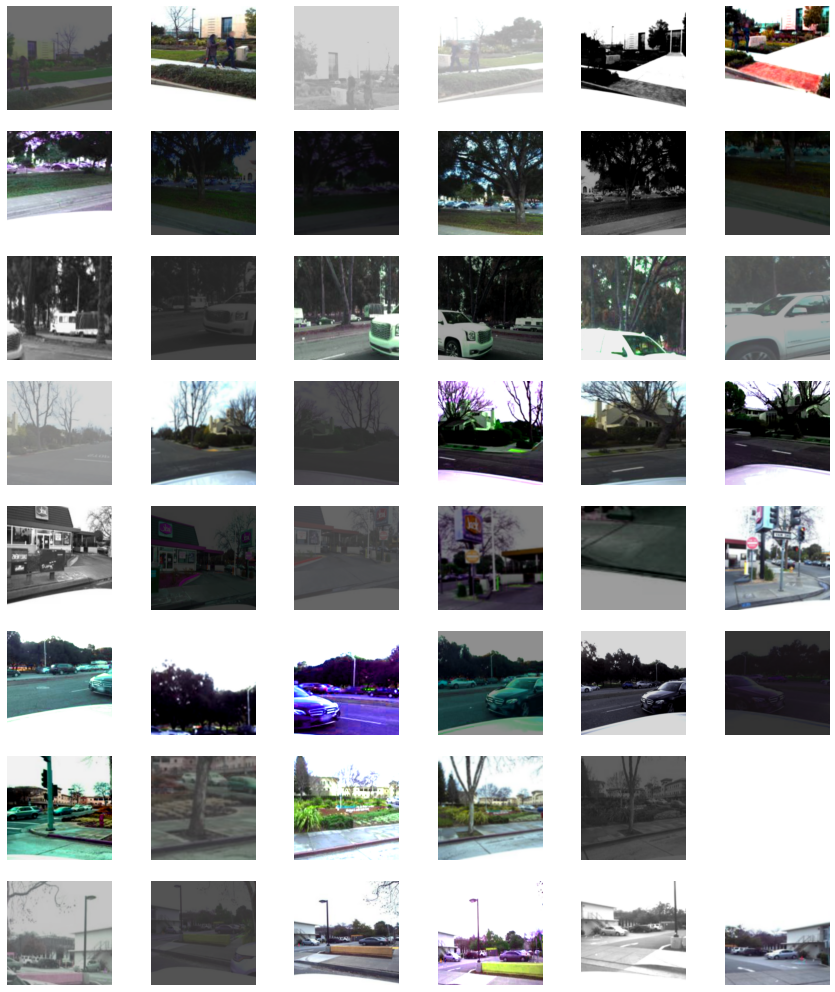

In [9]:
fig, ax = plt.subplots(8, 6, figsize=(15, 18))
for i in range(8):
    for j in range(6):
        xy = j // 3
        ind = j % 3
        ax[i, j].axis('off')
        ax[i, j].imshow(sample_batch[xy][i, ind].numpy().transpose(1, 2, 0))
plt.show()

In [2]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, seq_length, transform):
        self.image_folder = image_folder
        
        self.image_names = [
            'CAM_FRONT_LEFT.jpeg',
            'CAM_FRONT.jpeg',
            'CAM_FRONT_RIGHT.jpeg',
            'CAM_BACK_LEFT.jpeg',
            'CAM_BACK.jpeg',
            'CAM_BACK_RIGHT.jpeg',
            ]
        
        self.transform = transform
        assert seq_length <= 63
        self.seq_length = seq_length
        
        self.n_scene = 106
        self.n_sample = 126 - 2*self.seq_length + 1
        self.n_view = 6
    
    def __len__(self):
        return self.n_scene * self.n_sample * self.n_view
    
    def __getitem__(self, index):
        scene_id = index // (self.n_view * self.n_sample)
        rest = index % (self.n_view * self.n_sample)
        view_id = rest // self.n_sample
        sample_id = rest % self.n_sample
        
        images = []
        for i in range(2*self.seq_length):
            image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id+i}',
                                      self.image_names[view_id])
            image = Image.open(image_path)
            images.append(self.transform(image))
        image_tensor_x = torch.stack(images[:self.seq_length])
        image_tensor_y = torch.stack(images[self.seq_length:])
        
        return image_tensor_x, image_tensor_y

In [3]:
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return sample

In [4]:
class DataSetWrapper(object):
    def __init__(self, batch_size, seq_length, num_workers, s,
                 input_shape=(3, 256, 306), image_folder='data', augment=True):
        self.image_folder = image_folder

        self.batch_size = batch_size
        self.seq_length = seq_length
        self.num_workers = 0
        self.s = 1
        self.input_shape = (3, 256, 306)
        self.augment = augment
    
    def _pipeline_transform(self):
        # get a set of data augmentation transformations as described in the SimCLR paper.
        color_jitter = transforms.ColorJitter(0.8 * self.s, 0.8 * self.s, 0.8 * self.s, 0.2 * self.s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=self.input_shape[1:]),
                                              transforms.Resize([416, 416]),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomApply([color_jitter], p=0.8),
                                              transforms.RandomGrayscale(p=0.2),
                                              GaussianBlur(kernel_size=int(0.1 * 416)),
                                              transforms.ToTensor()])
        return data_transforms
    
    def get_data_loader(self):
        if self.augment:
            data_augment = self._pipeline_transform()
        else:
            data_augment = transforms.Compose([transforms.Resize([416, 416]), transforms.ToTensor()])

        unlabeled_trainset = UnlabeledDataset(self.image_folder, self.seq_length, data_augment)

        num_train = len(unlabeled_trainset)
        indices = list(range(num_train))
        np.random.shuffle(indices)

        train_sampler = SubsetRandomSampler(indices)

        train_loader = DataLoader(unlabeled_trainset, batch_size=self.batch_size, sampler=train_sampler,
                                  num_workers=self.num_workers, drop_last=True, shuffle=False)
        return train_loader

## Example

In [1]:
from dataset_wrapper import *

In [2]:
data = DataSetWrapper(batch_size=8, seq_length=3, num_workers=0, s=1)
train_loader = data.get_data_loader()

In [3]:
for i in train_loader:
    print(i[0].shape)
    print(i[1].shape)
    sample_batch = i
    break

torch.Size([8, 3, 3, 416, 416])
torch.Size([8, 3, 3, 416, 416])


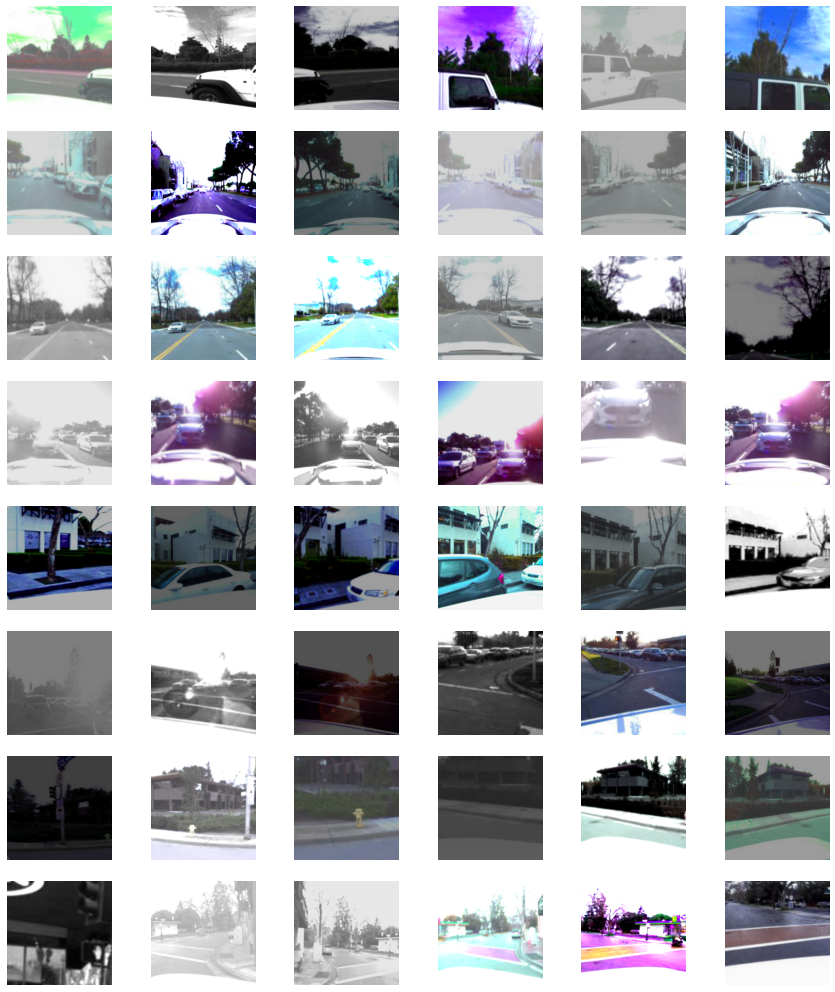

In [4]:
fig, ax = plt.subplots(8, 6, figsize=(15, 18))
for i in range(8):
    for j in range(6):
        xy = j // 3
        ind = j % 3
        ax[i, j].axis('off')
        ax[i, j].imshow(sample_batch[xy][i, ind].numpy().transpose(1, 2, 0))
plt.show()

## No augementation example

In [5]:
data = DataSetWrapper(batch_size=8, seq_length=3, num_workers=0, s=1, augment=False)
train_loader = data.get_data_loader()

In [6]:
for i in train_loader:
    print(i[0].shape)
    print(i[1].shape)
    sample_batch = i
    break

torch.Size([8, 3, 3, 416, 416])
torch.Size([8, 3, 3, 416, 416])


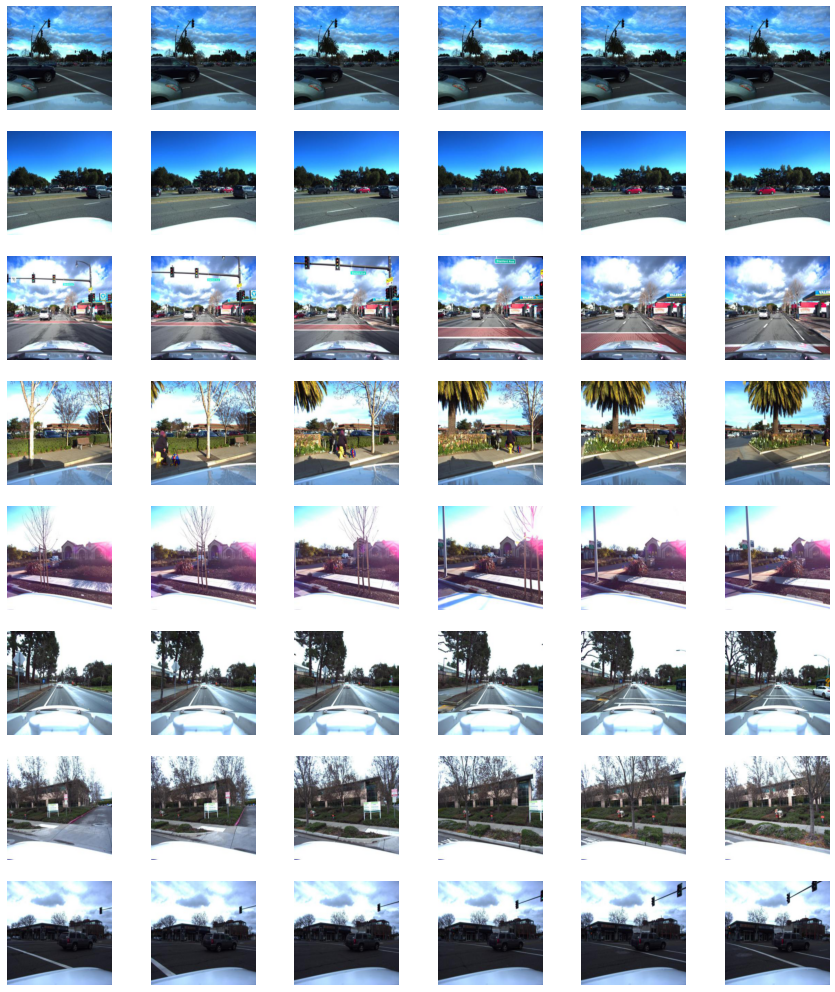

In [7]:
fig, ax = plt.subplots(8, 6, figsize=(15, 18))
for i in range(8):
    for j in range(6):
        xy = j // 3
        ind = j % 3
        ax[i, j].axis('off')
        ax[i, j].imshow(sample_batch[xy][i, ind].numpy().transpose(1, 2, 0))
plt.show()